# Evaluation of Synthetic Data Quality vs. Imbalance

This notebook evaluates and compares the quality of synthetic data generated by **CTGAN** and **TVAE** across six imbalance ratios (IRs). The analysis is structured around three core quality dimensions: **Statistical Fidelity**, **Downstream Utility**, and **Privacy Risk**.

## 1. Setup and Configuration

We'll start by importing libraries and defining key parameters for the analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.notebook import tqdm
import warnings

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import MinMaxScaler

from pymdma.tabular.measures.synthesis_val import (
    ImprovedPrecision,
    ImprovedRecall,
    Density,
    Coverage,
    Authenticity,
)

warnings.filterwarnings("ignore")

In [2]:
BASE_PATH = Path("../")
PROCESSED_PATH = BASE_PATH / "data" / "processed"
SYNTHETIC_PATH = BASE_PATH / "data" / "synthetic"
FIGURES_PATH = BASE_PATH / "results" / "figures"
FIGURES_PATH.mkdir(exist_ok=True, parents=True)

TARGET_FEATURE = "Severity"
IMBALANCE_RATIOS = [1, 5, 10, 20, 50, 100]

GENERATORS = ["ctgan", "tvae", "ddpm", "nflow"]
N_REPEATS = 3  

sns.set_theme(style="whitegrid")
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'sans-serif'

palette = sns.color_palette("colorblind", n_colors=len(GENERATORS))
GENERATOR_STYLES = {
    "CTGAN": {"color": palette[0], "marker": "o", "linestyle": "-"},
    "TVAE": {"color": palette[1], "marker": "s", "linestyle": "--"},
    "DDPM": {"color": palette[2], "marker": "X", "linestyle": "-."},
    "NFLOW": {"color": palette[3], "marker": "D", "linestyle": ":"},
}

## 3. Metric Calculation Pipeline

These helper functions encapsulate the logic for calculating utility and `pyMDMA` quality metrics. Adding docstrings improves readability and makes the code easier to maintain or reuse.

In [3]:
#Trains a RandomForest on synthetic data and evaluates its PR-AUC on real test data.
def calculate_utility_metrics(train_df: pd.DataFrame, test_df: pd.DataFrame) -> dict:
    X_train = train_df.drop(columns=[TARGET_FEATURE])
    y_train = train_df[TARGET_FEATURE]
    X_test = test_df.drop(columns=[TARGET_FEATURE])
    y_test = test_df[TARGET_FEATURE]

    model = RandomForestClassifier(random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)

    y_prob = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    
    return {"pr_auc": auc(recall, precision)}

#Calculates statistical quality and privacy metrics using pyMDMA.
def calculate_pyMDMA_metrics(real_df: pd.DataFrame, synthetic_df: pd.DataFrame) -> dict:
    real_features = real_df.drop(columns=[TARGET_FEATURE]).to_numpy()
    synthetic_features = synthetic_df.drop(columns=[TARGET_FEATURE]).to_numpy()

    metrics = {
        "precision": ImprovedPrecision(),
        "recall": ImprovedRecall(),
        "density": Density(),
        "coverage": Coverage(),
        "authenticity": Authenticity(),
    }
    
    results = {
        name: metric.compute(real_features, synthetic_features).dataset_level.value
        for name, metric in metrics.items()
    }
    return results

In [4]:
all_results_runs = []
test_df = pd.read_csv(PROCESSED_PATH / "test.csv")

pbar = tqdm(total=len(IMBALANCE_RATIOS) * len(GENERATORS) * N_REPEATS, desc="🚀 Processing Experiments")

for ir in IMBALANCE_RATIOS:
    for generator in GENERATORS:
        for run_id in range(1, N_REPEATS + 1):
            real_path = PROCESSED_PATH / f"train_imbalanced_ir_{ir}.csv"
            synth_path = SYNTHETIC_PATH / f"train_imbalanced_ir_{ir}_balanced_by_{generator}_run{run_id}.csv"

            if not synth_path.exists():
                warnings.warn(f"File not found, skipping: {synth_path.name}")
                pbar.update(1)
                continue

            real_df = pd.read_csv(real_path)
            synthetic_df = pd.read_csv(synth_path)

            pyMDMA_metrics = calculate_pyMDMA_metrics(real_df, synthetic_df)
            utility_metrics = calculate_utility_metrics(synthetic_df, test_df)

            result_entry = {
                "ir": ir,
                "generator": generator.upper(),
                "run_id": run_id,
                **pyMDMA_metrics,
                **utility_metrics
            }
            all_results_runs.append(result_entry)
            pbar.update(1)

pbar.close()
raw_results_df = pd.DataFrame(all_results_runs)

agg_metrics = {col: ['mean', 'std'] for col in raw_results_df.columns if col not in ['ir', 'generator', 'run_id']}

results_df = raw_results_df.groupby(['ir', 'generator']).agg(agg_metrics).reset_index()

results_df.columns = ['_'.join(col).strip() if col[1] else col[0] for col in results_df.columns.values]

print("Evaluation and aggregation complete.")
results_df.head()

🚀 Processing Experiments:   0%|          | 0/72 [00:00<?, ?it/s]

Evaluation and aggregation complete.


,ir,generator,precision_mean,precision_std,recall_mean,recall_std,density_mean,density_std,coverage_mean,coverage_std,authenticity_mean,authenticity_std,pr_auc_mean,pr_auc_std
0,5,CTGAN,0.999191,0.000701,1.0,0.0,1.241181,0.036650,1.0,0.0,0.119741,0.056953,0.779760,0.018494
1,5,DDPM,0.989887,0.003054,1.0,0.0,1.238350,0.001058,1.0,0.0,0.184871,0.004595,0.823040,0.023409
2,5,NFLOW,0.987460,0.002803,1.0,0.0,1.201456,0.024986,1.0,0.0,0.192152,0.012455,0.818209,0.022871
3,5,TVAE,0.997573,0.000000,1.0,0.0,1.233252,0.000000,1.0,0.0,0.138350,0.000000,0.827377,0.000000
4,10,CTGAN,0.995146,0.005290,1.0,0.0,1.324191,0.074346,1.0,0.0,0.075647,0.021241,0.802298,0.033486


## 4. Analysis and Visualization

### 4.1. Performance Summary


In [5]:
metrics_to_pivot = ['precision_mean', 'density_mean', 'pr_auc_mean', 'authenticity_mean']

summary_pivot = results_df.pivot_table(
    index='ir', 
    columns='generator', 
    values=metrics_to_pivot
)

def clean_col_names(col):
    metric, generator = col
    clean_metric = metric.replace('_mean', '').replace('pr_auc', 'PR-AUC')
    return f'{generator}_{clean_metric}'

summary_pivot.columns = [clean_col_names(col) for col in summary_pivot.columns]

styled_summary = summary_pivot.style.highlight_max(
    props='font-weight:bold; background-color:#a2d2ff;', 
    axis=1
).format("{:.3f}")

display(styled_summary)

,CTGAN_authenticity,DDPM_authenticity,NFLOW_authenticity,TVAE_authenticity,CTGAN_density,DDPM_density,NFLOW_density,TVAE_density,CTGAN_PR-AUC,DDPM_PR-AUC,NFLOW_PR-AUC,TVAE_PR-AUC,CTGAN_precision,DDPM_precision,NFLOW_precision,TVAE_precision
ir,,,,,,,,,,,,,,,,
5,0.120,0.185,0.192,0.138,1.241,1.238,1.201,1.233,0.780,0.823,0.818,0.827,0.999,0.990,0.987,0.998
10,0.076,0.206,0.204,0.036,1.324,1.214,1.175,1.334,0.802,0.831,0.816,0.828,0.995,0.988,0.988,1.000
20,0.195,0.214,0.208,0.216,1.225,1.208,1.158,1.496,0.805,0.824,0.822,0.836,0.996,0.992,0.989,1.000
50,0.188,0.228,0.232,0.058,1.155,1.199,1.167,1.399,0.815,0.814,0.818,0.814,0.983,0.992,0.994,1.000
100,0.230,0.213,0.220,0.062,1.210,1.198,1.168,1.298,0.785,0.796,0.792,0.719,0.998,0.993,0.990,0.998


### 4.2. Performance Trends vs. Imbalance Ratio

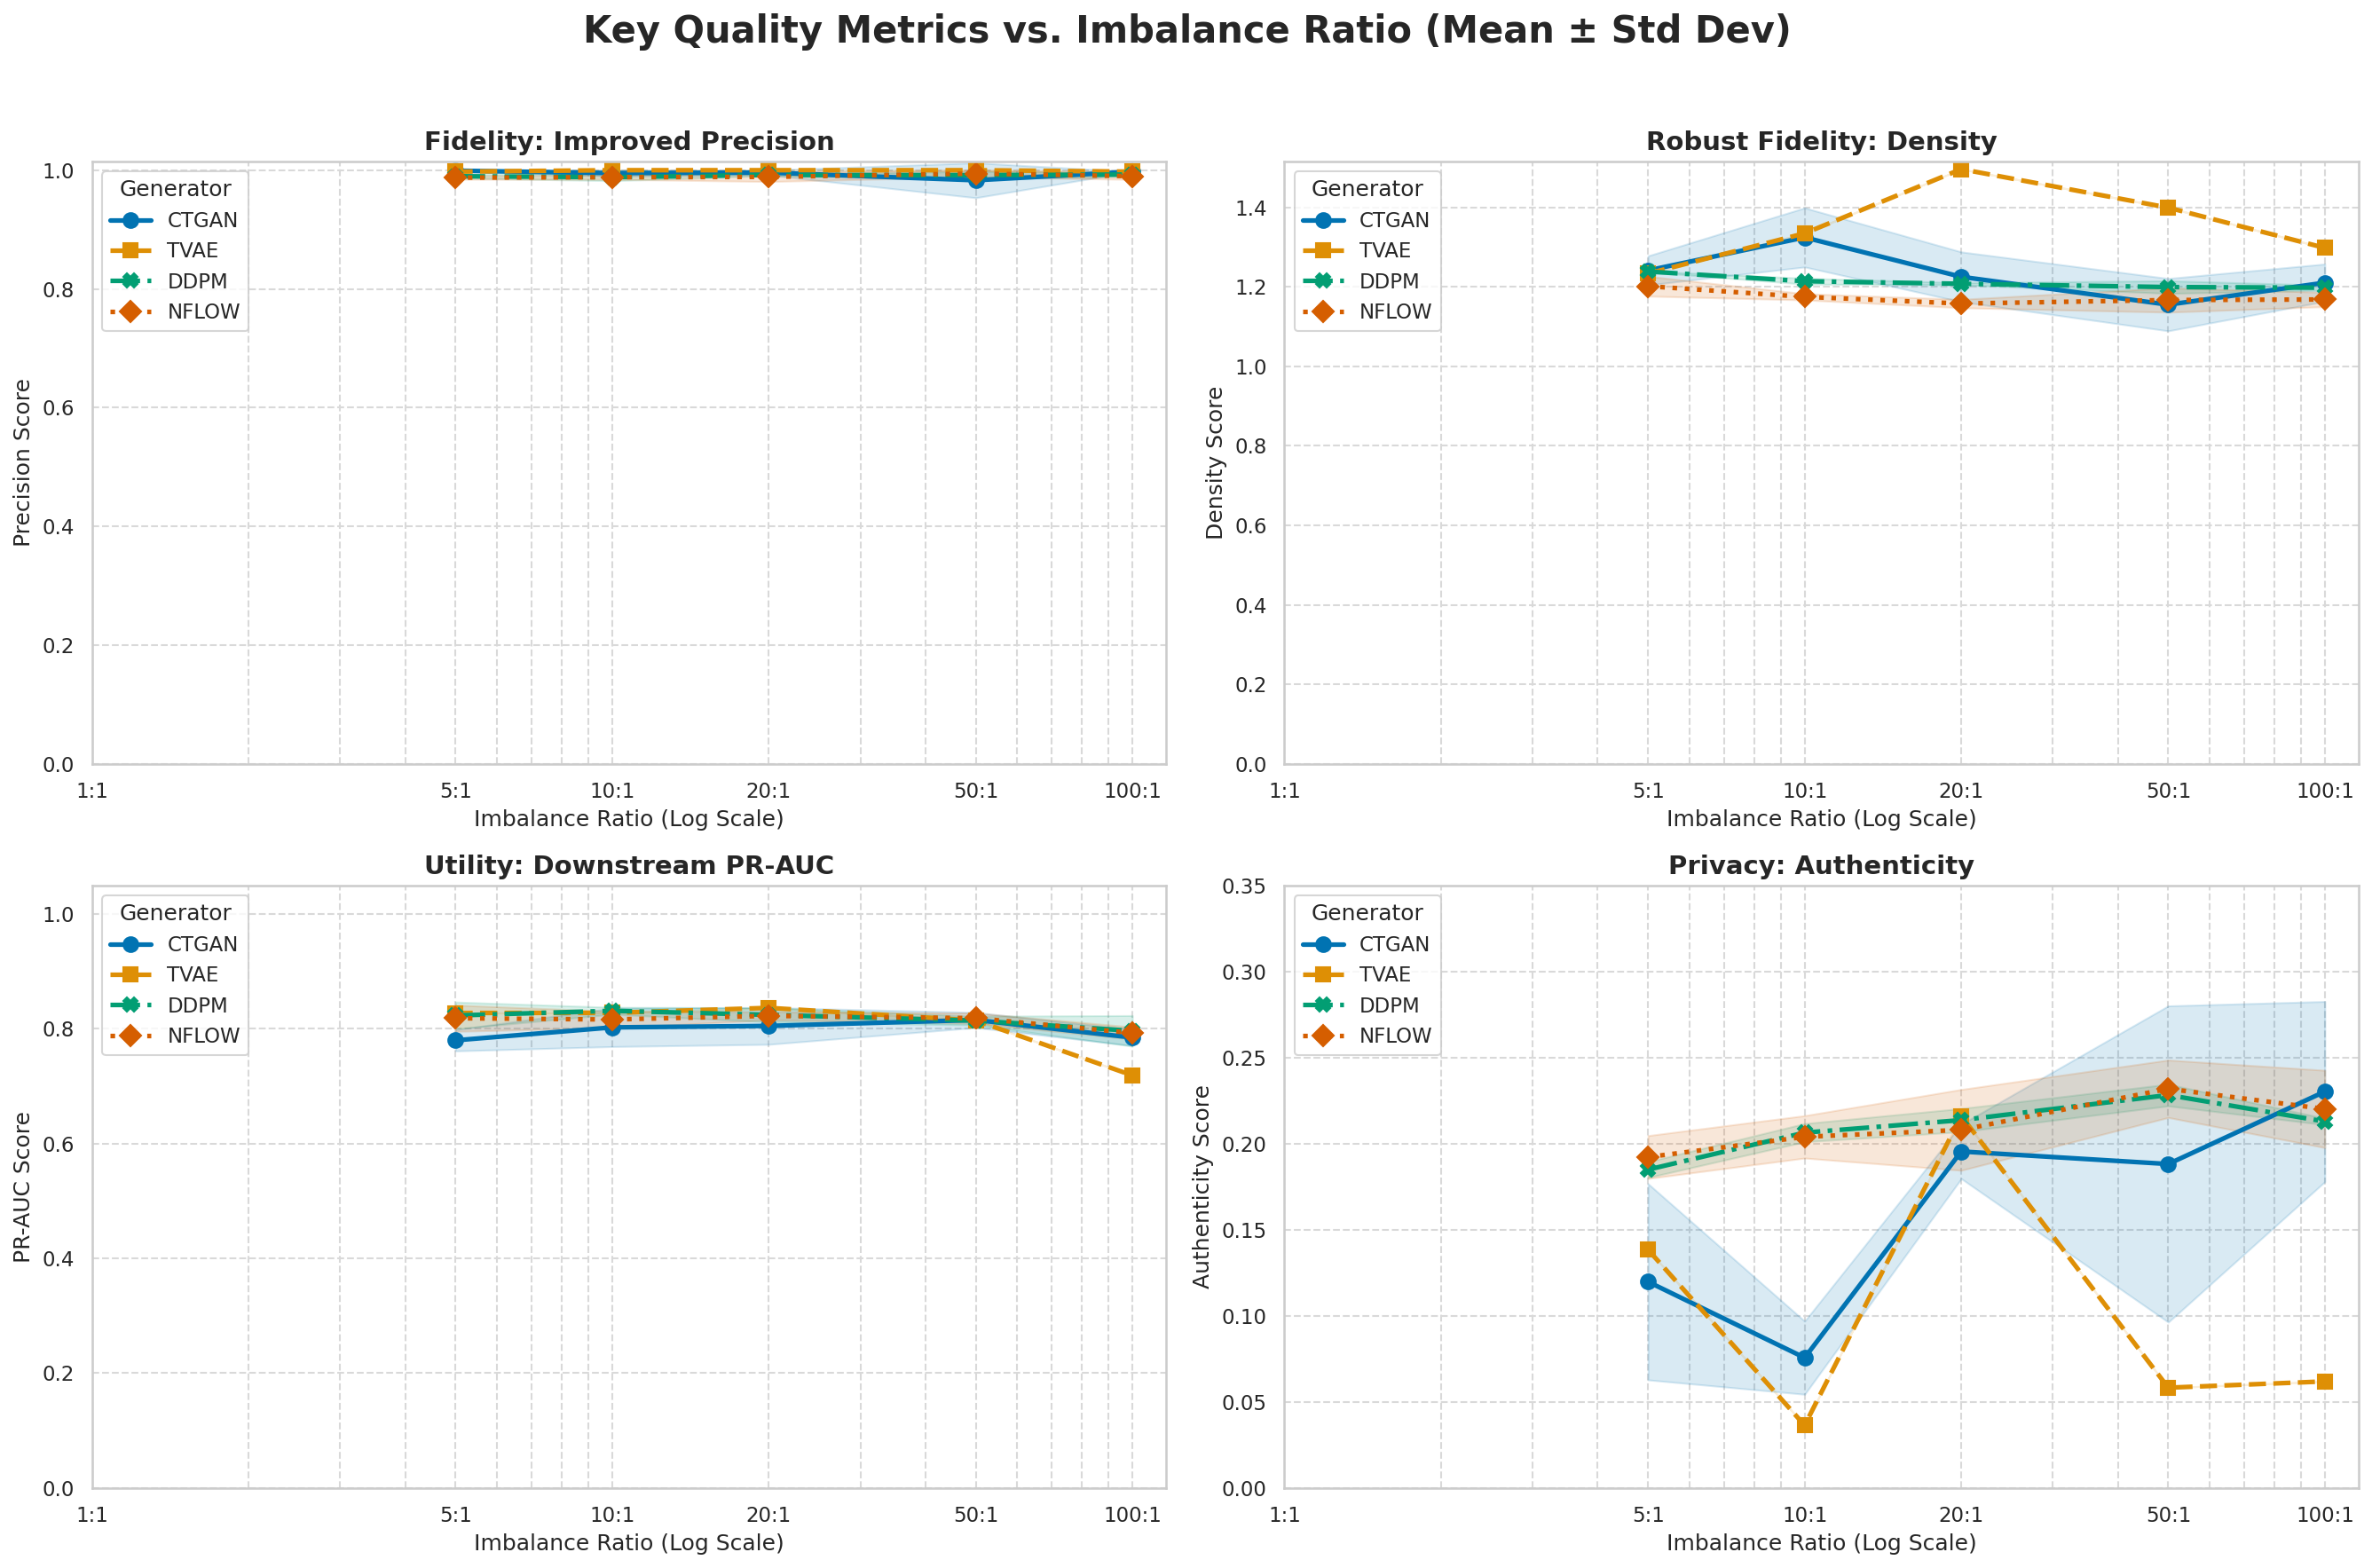

In [6]:
def plot_metric_trend(data, metric, ax, title, y_label, y_lim=(0, None)):
    metric_mean = f"{metric}_mean"
    metric_std = f"{metric}_std"
    
    for gen, style in GENERATOR_STYLES.items():
        gen_data = data[data['generator'] == gen]
        if gen_data.empty:
            continue
            
        # Plot the mean line
        ax.plot(
            gen_data['ir'], 
            gen_data[metric_mean],
            color=style['color'],
            marker=style['marker'],
            linestyle=style['linestyle'],
            label=gen,
            markersize=8, 
            linewidth=2.5
        )
        
        # Add the standard deviation error band
        std_dev = gen_data[metric_std].fillna(0)
        ax.fill_between(
            gen_data['ir'],
            gen_data[metric_mean] - std_dev,
            gen_data[metric_mean] + std_dev,
            color=style['color'],
            alpha=0.15
        )

    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_xlabel('Imbalance Ratio (Log Scale)', fontsize=12)
    ax.set_xscale('log')
    ax.set_xticks(IMBALANCE_RATIOS)
    ax.set_xticklabels([f"{ir}:1" for ir in IMBALANCE_RATIOS])
    if y_lim:
        ax.set_ylim(y_lim)
    ax.legend(title='Generator', loc='best')
    ax.grid(True, which="both", ls="--", c='0.85')

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Key Quality Metrics vs. Imbalance Ratio (Mean ± Std Dev)', fontsize=20, fontweight='bold')

plot_metric_trend(results_df, 'precision', axes[0, 0], 'Fidelity: Improved Precision', 'Precision Score')
plot_metric_trend(results_df, 'density', axes[0, 1], 'Robust Fidelity: Density', 'Density Score')
plot_metric_trend(results_df, 'pr_auc', axes[1, 0], 'Utility: Downstream PR-AUC', 'PR-AUC Score', y_lim=(0, 1.05))
plot_metric_trend(results_df, 'authenticity', axes[1, 1], 'Privacy: Authenticity', 'Authenticity Score', y_lim=(0, 0.35))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(FIGURES_PATH / 'improved_quality_trends_with_error.png', dpi=300)
plt.show()

### 4.3. Multi-Dimensional Quality Profile (Radar Chart)

Let's normalize all metrics to a 0-1 scale to plot them on the same axes.

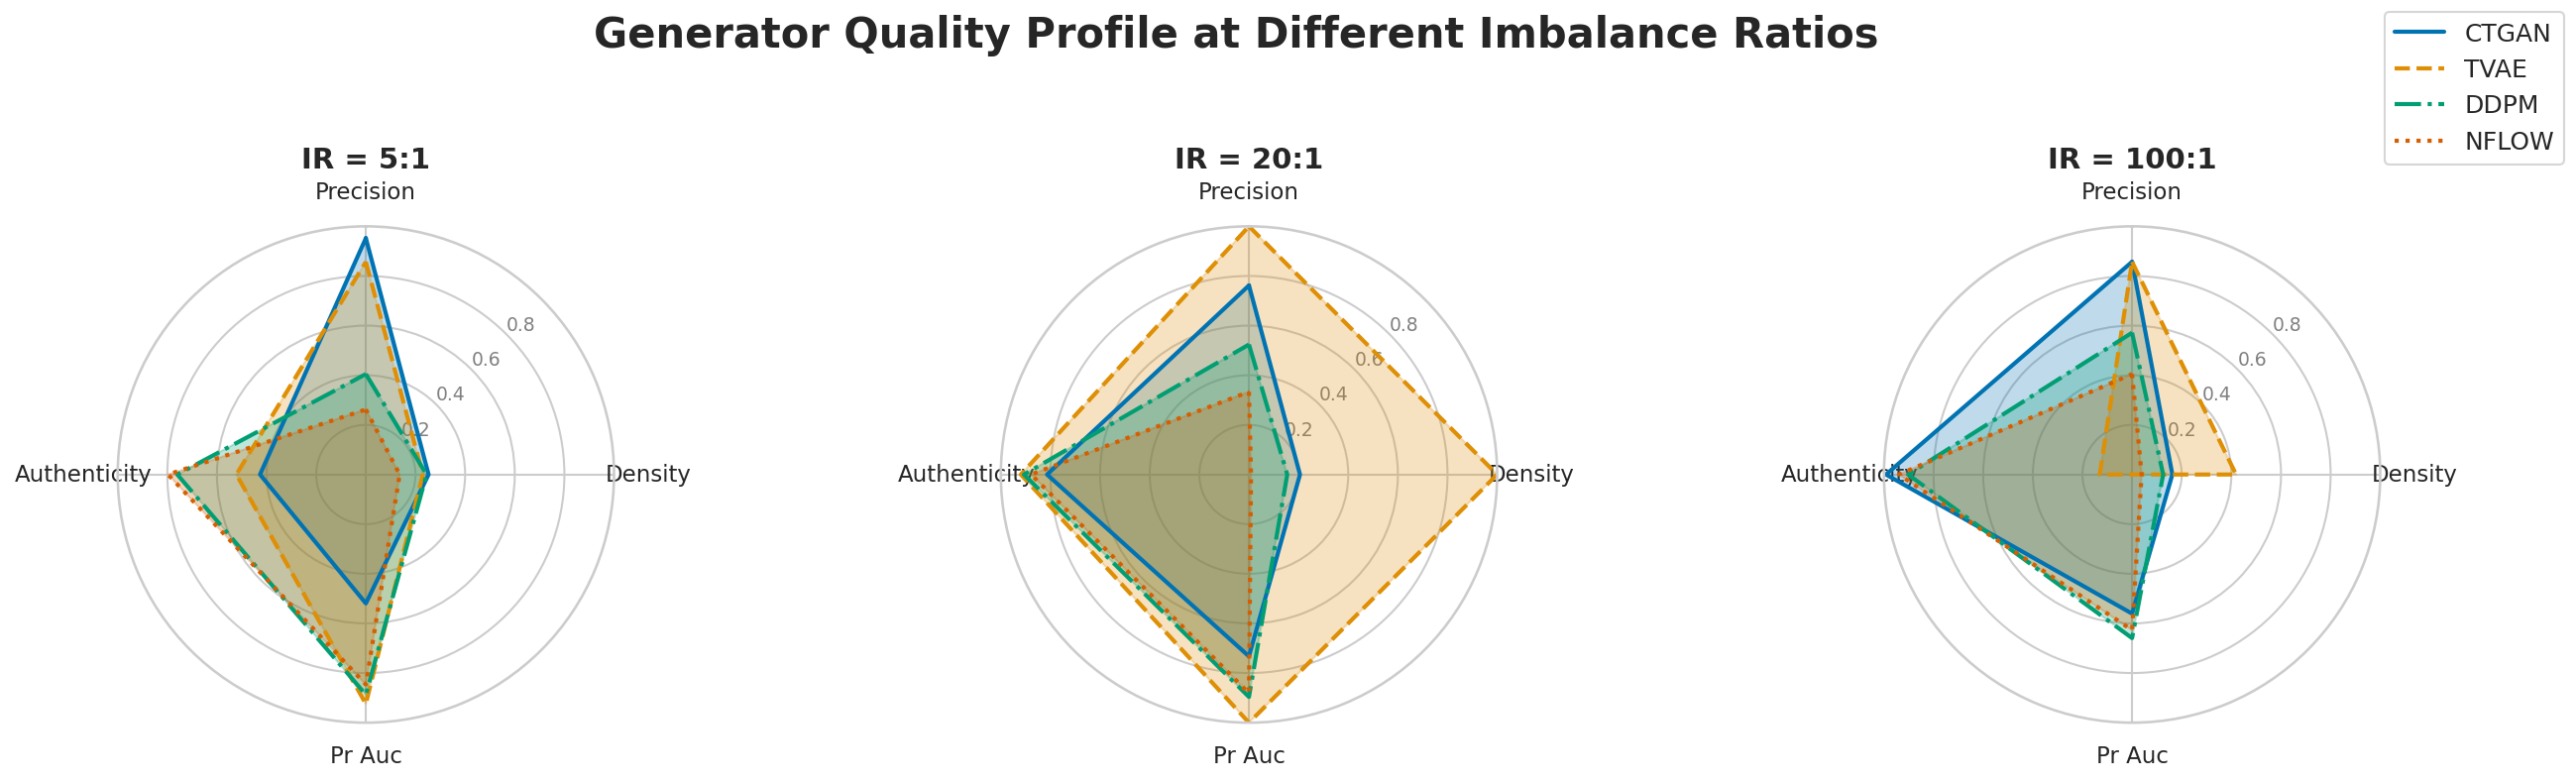

In [7]:
metrics_for_radar = ['precision', 'density', 'pr_auc', 'authenticity']
radar_df = results_df.copy()

for metric in metrics_for_radar:
    radar_df[metric] = radar_df[f"{metric}_mean"]

scaler = MinMaxScaler()
radar_df[metrics_for_radar] = scaler.fit_transform(radar_df[metrics_for_radar])

def plot_radar_chart(data, ir_level, ax):
    df_ir = data[data['ir'] == ir_level]
    labels = metrics_for_radar
    num_vars = len(labels)

    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1] 

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    for gen, style in GENERATOR_STYLES.items():
        gen_data = df_ir[df_ir['generator'] == gen]
        if gen_data.empty: continue
        values = gen_data[labels].values.flatten().tolist()
        values += values[:1] 
        ax.plot(angles, values, color=style['color'], linewidth=2, linestyle=style['linestyle'], label=gen)
        ax.fill(angles, values, color=style['color'], alpha=0.25)

    ax.set_rlabel_position(180 / num_vars)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([l.replace('_', ' ').title() for l in labels], size=11)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8])
    ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8"], color="grey", size=9)
    ax.set_ylim(0, 1)
    ax.set_title(f"IR = {ir_level}:1", size=14, weight='bold', position=(0.5, 1.1))

fig, axes = plt.subplots(figsize=(18, 5), ncols=3, subplot_kw=dict(projection='polar'))
fig.suptitle('Generator Quality Profile at Different Imbalance Ratios', fontsize=20, fontweight='bold', y=1.05)

plot_radar_chart(radar_df, 5, axes[0])
plot_radar_chart(radar_df, 20, axes[1])
plot_radar_chart(radar_df, 100, axes[2])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize=12)

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'improved_radar_profiles.png', dpi=300, bbox_inches='tight')
plt.show()